In [1]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
from utils import * # tic toc imshow
%load_ext line_profiler

import higra as hg
hg.set_trace(False)
#hg.logger_register_print_callback()

Image size: (481, 321)


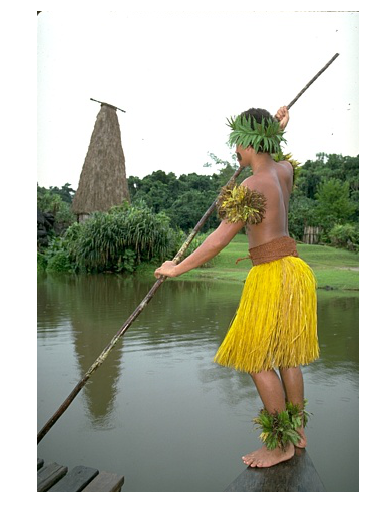

In [2]:
image = imageio.imread("data/101087.jpg")
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float64)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

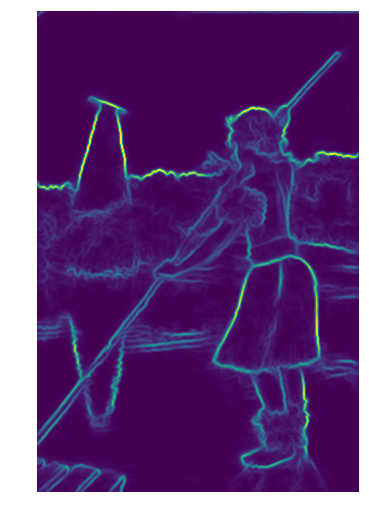

In [3]:
sed_gradient = imageio.imread("data/101087_SED.png")
sed_gradient = sed_gradient.astype(np.float64)/255
imshow(sed_gradient)

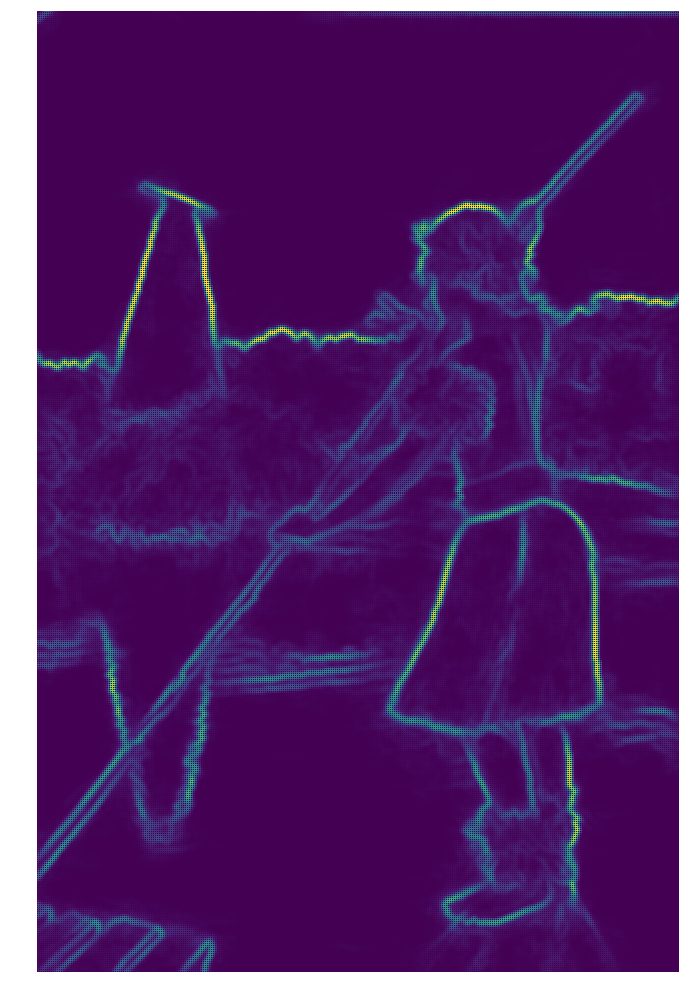

In [4]:
graph = hg.get_4_adjacency_graph(size)
gradient_flatten = sed_gradient.reshape((-1,)) # spatial dimensions of the image are irrelevant and must be flatten 
edge_weights = hg.weight_graph(graph, gradient_flatten, hg.WeightFunction.mean)
sm = hg.graph_4_adjacency_2_khalimsky(graph, edge_weights=edge_weights)
imshow(sm)


## WS Area on Pixels

In [5]:
def ws_area(graph, edge_weights):
    tree = hg.bpt_canonical(graph, edge_weights)
    leaf_graph = hg.get_attribute(tree,"leaf_graph")
    area = hg.attribute_area(tree)
    area_corrected = hg.compute_bpt_merge_attribute(tree, area)
    mst = hg.get_attribute(tree, "mst")
    mst_weights = area_corrected[tree.num_leaves():]
    tree = hg.bpt_canonical(mst, edge_weights=mst_weights)
    sm = hg.saliency(tree)
    return sm

In [6]:
%lprun -f ws_area ws_area(graph, edge_weights)

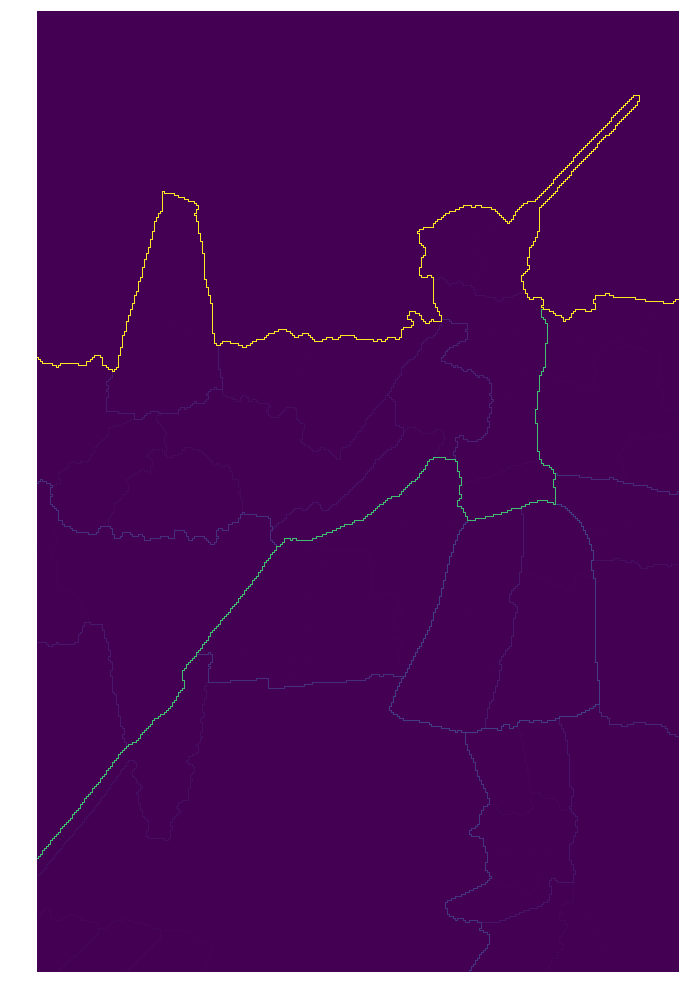

In [7]:
sm_1 = ws_area(graph, edge_weights)
imshow(hg.graph_4_adjacency_2_khalimsky(graph, edge_weights=sm_1))

## WS Area with RAG

In [8]:
%timeit vertex_labels = hg.labelisation_watershed(graph)

9.39 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


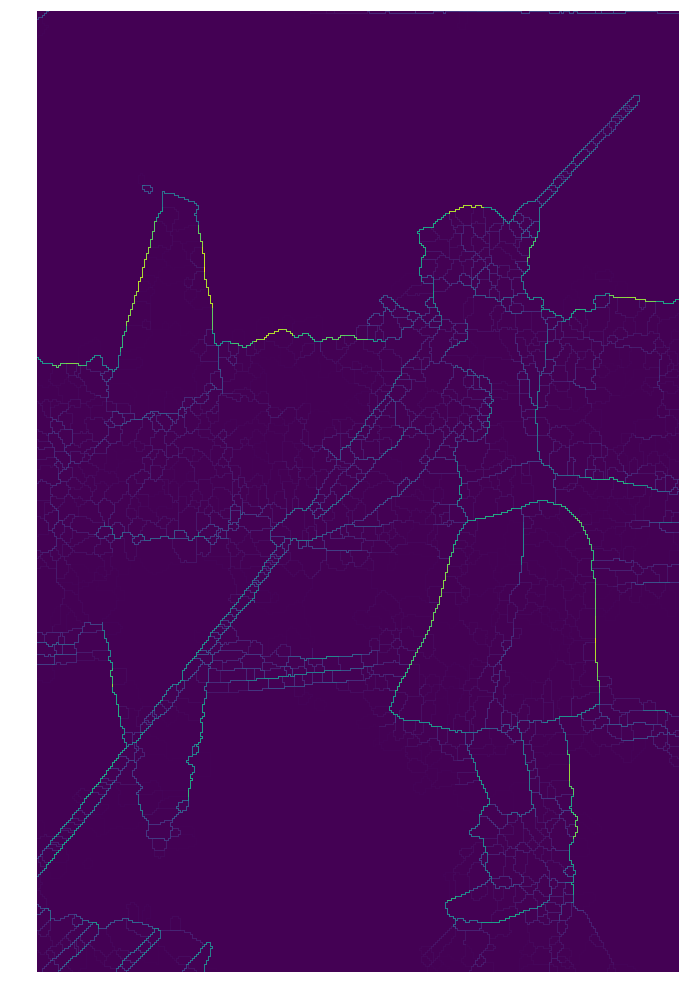

In [9]:
vertex_labels = hg.labelisation_watershed(graph)
rag = hg.make_region_adjacency_graph(graph, vertex_labels)
rag_edge_weights = hg.rag_accumulate_on_edges(rag, hg.Accumulators.min)
original_reweight = hg.rag_back_project_edge_weights(rag, rag_edge_weights)
sm = hg.graph_4_adjacency_2_khalimsky(graph, edge_weights=original_reweight)
imshow(sm)

In [10]:
sm_rag = ws_area(rag, rag_edge_weights)

In [11]:
%lprun -f ws_area ws_area(rag, rag_edge_weights)


In [12]:
def ws_area_rag(graph, edge_weights):
    vertex_labels = hg.labelisation_watershed(graph)
    rag = hg.make_region_adjacency_graph(graph, vertex_labels)
    rag_area = hg.rag_accumulate_on_vertices(rag, hg.Accumulators.sum, np.ones((graph.num_vertices())))
    hg.set_attribute(rag, "vertex_area", rag_area)
    rag_edge_weights = hg.rag_accumulate_on_edges(rag, hg.Accumulators.min)
    sm_rag = ws_area(rag, rag_edge_weights)
    return hg.rag_back_project_edge_weights(rag, sm_rag)

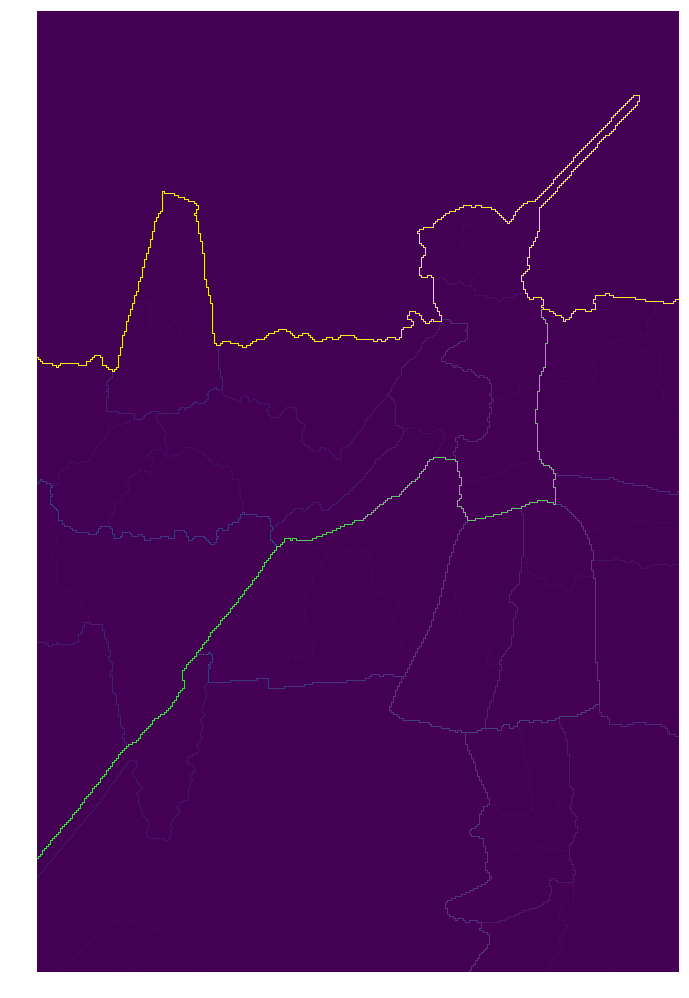

In [13]:
sm_op = ws_area_rag(graph, edge_weights)
sm_viz = hg.graph_4_adjacency_2_khalimsky(graph, edge_weights=sm_op)
imshow(sm_viz)

In [14]:
%lprun -f ws_area_rag ws_area_rag(graph, edge_weights)

In [15]:
tree = hg.bpt_canonical(graph, edge_weights)

In [16]:
lca = hg.LCAFast(tree)

In [17]:
%timeit lca = hg.LCAFast(tree)

76.5 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit smlca = lca.lca(graph)

17.5 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
